In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
%matplotlib inline

In [2]:
base_dir = "C:/Users/joanc/PycharmProjects/face_detection/"

In [3]:
def plot_single_img(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)

In [4]:
def slide_window(img, window_size=36):
    h, w, _ = img.shape
    for i in range(0, h-window_size, window_size//2):
        for j in range(0, w-window_size, window_size//2):
            yield img[i:i+window_size, j:j+window_size], i, j

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


img = np.array(Image.open(base_dir+"dataset/train_images/1/Image000644.jpg"))

(43, 43)


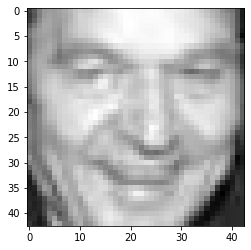

In [5]:
def zoom(img, factor=1.2):
    return cv2.resize(img, dsize=None,fx=factor, fy=factor)

zoomed = zoom(img)
print(zoomed.shape)
plot_single_img(zoomed)

In [6]:
# bugg fix for some computers
# it makes tensorflow use only the part of the gpu that is needed
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
def calculate_bounding_box(y, x, original_size, actual_size, window_size):
    scale = original_size[0] / actual_size[0], original_size[1] / actual_size[1]
#     print(scale)
    return int(y*scale[0]), int(x*scale[1]), int(window_size*scale[0])
    

def predict_pyramid(model, img, zoom_factor=1.2, window_size=36, threshold=0.5):
    """
    predictions are done sequentially so model is very slow
    returns a list of bounding boxes
    bounding boxes are defined using by (y, x, h, w) where y,x are the coordinates of the left corner and
    h,w represent the height and width of the bounding box
    """
    boxes = []
    orig_h, orig_w = img.shape
    for it in range(1):
        img = img.reshape(*img.shape, 1)
        slider = slide_window(img, window_size)
        for window, i, j in slider:
            prediction = model.predict(np.array([window]))
            if prediction > 0.7:
#                 plot_single_img(window[:,:,0])
                boxes.append(calculate_bounding_box(i, j, (orig_h, orig_w), img.shape, window_size))
        img = zoom(img, zoom_factor)
    return boxes
            
            
model = load_model("saved_models/face_classifier.h5", )
new_img = cv2.imread("C:/Users/joanc/Downloads/Mixed-Raced-family-e1513084049363-600x320.jpg",cv2.IMREAD_GRAYSCALE)
print(new_img.shape)
new_img = cv2.resize(new_img, None, fx=0.5, fy=0.5)
boxes = predict_pyramid(model, new_img/255)
%time predict_pyramid(model, new_img/255)

(320, 600)
Wall time: 2.67 s


[(18, 144, 36), (90, 54, 36), (90, 162, 36)]

In [8]:
print(boxes)
print(len(boxes))

[(18, 144, 36), (90, 54, 36), (90, 162, 36)]
3


(160, 300)


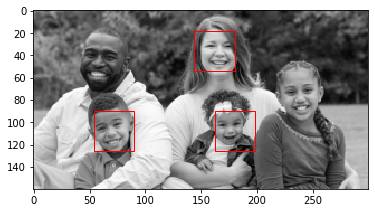

In [9]:
from matplotlib.patches import Rectangle
print(new_img.shape)
new_img = cv2.cvtColor(new_img, cv2.COLOR_GRAY2RGB)
plt.imshow(new_img)

# Add the patch to the Axes
for y, x, s in boxes:
    plt.gca().add_patch(Rectangle((x,y),s,s,linewidth=1,edgecolor='r',facecolor='none'))

In [10]:
new_img = cv2.imread("C:/Users/joanc/Downloads/Mixed-Raced-family-e1513084049363-600x320.jpg",cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(new_img, None, fx=0.5, fy=0.5)

In [18]:
def slide_window(img, window_size=36, batch_size=64, stride=5):
    h, w, _ = img.shape
    batch = np.zeros((batch_size, window_size, window_size, 1))
    count = 0
    for i in range(0, h-window_size, stride):
        for j in range(0, w-window_size, stride):
            batch[count] = img[i:i+window_size, j:j+window_size]
            count += 1
            if count == batch_size:
                count = 0
                yield batch
    yield batch[:count]

def calculate_bounding_box(y, x, original_shape, actual_shape, window_size):
    scale = original_shape[0] / actual_shape[0], original_shape[1] / actual_shape[1]
    return int(y*scale[0]), int(x*scale[1]), int(window_size*scale[0])
    
def bounding_boxes(img, window_size, stride, original_shape):
    h, w, _ = img.shape
    for i in range(0, h-window_size, stride):
        for j in range(0, w-window_size, stride):
            yield calculate_bounding_box(i, j, original_shape, img.shape[:2], window_size) 
            
gen = slide_window(new_img.reshape(*new_img.shape, 1), stride=2)

In [25]:
from math import ceil
def calculate_nb_steps(img_shape, window_size, stride, batch_size):
    print("args nb steps",img_shape, window_size, stride, batch_size)
    return ceil(((img_shape[0] - window_size) // stride) * ((img_shape[0] - window_size) // stride) / batch_size)

def predict_pyramid(model, img, threshold=0.5, zoom_factor=1.2, zoom_iterations=1, window_size=36, batch_size=64, stride=5):
    img = img / 255
    original_shape = img.shape
    img = img.reshape(*img.shape, 1)
    print(img.shape)
    boxes = []
    for it in range(zoom_iterations):
        generator = slide_window(img, window_size=window_size, stride=stride, batch_size=batch_size)
        nb_steps = calculate_nb_steps(img.shape, window_size, stride, batch_size)
        print(nb_steps*batch_size)
        probabilities = model.predict_generator(generator, steps=nb_steps*1000, workers=0)
        print("probs.shape", probabilities.shape)
        bounding_boxes_gen = bounding_boxes(img, window_size=window_size, 
                                            stride=stride, original_shape=original_shape)
        for it in range(len(probabilities)):
            box = next(bounding_boxes_gen)
#             print(box)
            if probabilities[it] >= 0.999:
                boxes.append(box)
        img = zoom(img, zoom_factor)
        img = img.reshape(*img.shape, 1)
    return boxes
        
boxes =  predict_pyramid(model, new_img, stride=2, batch_size=64)


(160, 300, 1)
args nb steps (160, 300, 1) 36 2 64
3904
probs.shape (8184, 1)


In [26]:
print(boxes)

[(4, 118, 36), (18, 144, 36), (18, 146, 36), (18, 148, 36), (18, 150, 36), (20, 142, 36), (20, 144, 36), (20, 146, 36), (20, 148, 36), (20, 150, 36), (20, 152, 36), (22, 142, 36), (22, 144, 36), (22, 146, 36), (22, 148, 36), (22, 150, 36), (22, 152, 36), (22, 154, 36), (24, 144, 36), (24, 146, 36), (24, 148, 36), (24, 150, 36), (24, 152, 36), (26, 144, 36), (26, 146, 36), (26, 148, 36), (26, 150, 36), (26, 152, 36), (28, 38, 36), (28, 40, 36), (28, 42, 36), (28, 44, 36), (28, 46, 36), (28, 148, 36), (30, 38, 36), (30, 40, 36), (30, 42, 36), (30, 44, 36), (30, 46, 36), (32, 40, 36), (32, 42, 36), (32, 44, 36), (32, 46, 36), (34, 40, 36), (34, 42, 36), (34, 44, 36), (34, 46, 36), (36, 46, 36), (58, 218, 36), (58, 222, 36), (60, 216, 36), (60, 218, 36), (60, 220, 36), (60, 222, 36), (60, 224, 36), (60, 226, 36), (62, 216, 36), (62, 218, 36), (62, 220, 36), (62, 222, 36), (62, 224, 36), (62, 226, 36), (64, 216, 36), (64, 218, 36), (64, 220, 36), (64, 222, 36), (64, 224, 36), (64, 226, 36),

(160, 300)


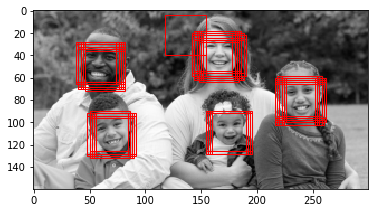

In [27]:
from matplotlib.patches import Rectangle
print(new_img.shape)
plot_img = cv2.cvtColor(new_img, cv2.COLOR_GRAY2RGB)
plt.imshow(plot_img)

# Add the patch to the Axes
for y, x, s in boxes:
    plt.gca().add_patch(Rectangle((x,y),s,s,linewidth=1,edgecolor='r',facecolor='none'))